# Dataset Loader for Vitabnet
This notebook demonstrates how to load and visualize the Vitabnet dataset using custom dataset loaders.

In [1]:
# Import required libraries
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

# Add the src directory to path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

from config import *
from datasets.table_dataset import PubTabNetDataset
from datasets.cell_dataset import CellDataset

## Configuration and Dataset Setup
Set up the dataset configurations for both table-level and cell-level datasets.

In [2]:
json_path = VITABSET_TEST_JSON
img_path = VITABSET_TEST_IMAGE_ROOT

table_dataset_config = {
    'ann_file': json_path,
    'data_prefix': {'img_path': img_path},
    'task_type': 'both',
    'split_filter': None,  # Load all splits available in the file
    'max_structure_len': 500,
    'max_cell_len': 500,
    'ignore_empty_cells': True
}

if os.path.exists(img_path):
    print(f"✓ Image root exists: {img_path}")
    # Count image files
    image_files = []
    for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
        image_files.extend([f for f in os.listdir(img_path) if f.lower().endswith(ext)])
    print(f"  Found {len(image_files)} image files")
else:
    print(f"✗ Image root not found: {img_path}")

if os.path.exists(json_path):
    print(f"✓ Annotation file exists: {json_path}")
    file_size = os.path.getsize(json_path) / (1024 * 1024)  # MB
    print(f"  File size: {file_size:.2f} MB")
else:
    print(f"✗ Annotation file not found: {json_path}")

table_dataset = PubTabNetDataset(**table_dataset_config)

print('Settup DONE!')

✓ Image root exists: F:/data\vitabset\test
  Found 10209 image files
✓ Annotation file exists: F:/data\vitabset\test.bz2
  File size: 6.02 MB
Settup DONE!


In [3]:
print("Loading PubTabNet table dataset...")
table_dataset = PubTabNetDataset(**table_dataset_config)
print(f"Table dataset loaded: {len(table_dataset)} samples")
print(f"\nTable Dataset Info:\n{table_dataset}")

Loading PubTabNet table dataset...
Table dataset loaded: 10209 samples

Table Dataset Info:
PubTabNetDataset(task_type=both, split_filter=None, num_samples=10209, ann_file=F:/data\vitabset\test.bz2)


In [4]:
import random
sample_data = table_dataset[random.randint(0, len(table_dataset) - 1)]
print(f"  Keys: {list(sample_data.keys())}")
print(f"  Image path: {sample_data.get('img_path', 'N/A')}")
print(f"  Number of instances: {len(sample_data.get('instances', []))}")

  Keys: ['img_path', 'sample_idx', 'instances', 'img_info']
  Image path: F:/data\vitabset\test\89346.png
  Number of instances: 37


In [5]:
cell_dataset_config = {
    'ann_file': json_path,
    'data_prefix': {'img_path': img_path},
    'ignore_empty_cells': True
}
print("\nLoading Cell dataset...")
cell_dataset = CellDataset(**cell_dataset_config)
print(f"Cell dataset loaded: {len(cell_dataset)} samples")
print(f"\nCell Dataset Info:\n{cell_dataset}")


Loading Cell dataset...
Cell dataset loaded: 522260 samples

Cell Dataset Info:
CellDataset(task_type=content, split_filter=None, num_samples=522260, ann_file=F:/data\vitabset\test.bz2)


In [6]:
cell_sample_data = cell_dataset[random.randint(0, len(cell_dataset) - 1)]
print(f"  Keys: {list(cell_sample_data.keys())}")
print(f"  Image path: {cell_sample_data.get('img_path', 'N/A')}")
print(f"  Cell bbox: {cell_sample_data.get('bbox', 'N/A')}")
    

  Keys: ['img_path', 'height', 'width', 'bbox', 'sample_idx', 'original_imgid', 'instances', 'img']
  Image path: F:/data\vitabset\test\177560.png
  Cell bbox: [421, 361, 707, 388]


## Display Table Samples
Visualize several table samples with their structure and cell annotations.

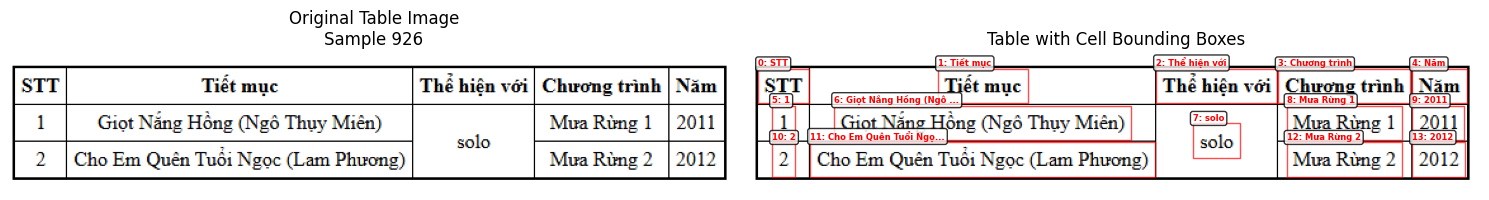


Sample 926 Details:
Image path: F:/data\vitabset\test\158492.png
Image size: (574, 108)
Split: test
Structure instances: 1
Content instances: 14
Structure text: <thead><tr><td></td><td></td><td></td><td></td><td></td></tr></thead><tbody><tr><td></td><td></td><t...
First few cell texts:
  Cell 0: 'STT' at [4, 12, 44, 39]
  Cell 1: 'Tiết mục' at [146, 12, 217, 39]
  Cell 2: 'Thể hiện với' at [318, 12, 413, 39]
  Cell 3: 'Chương trình' at [414, 12, 518, 39]
  Cell 4: 'Năm' at [520, 12, 563, 39]


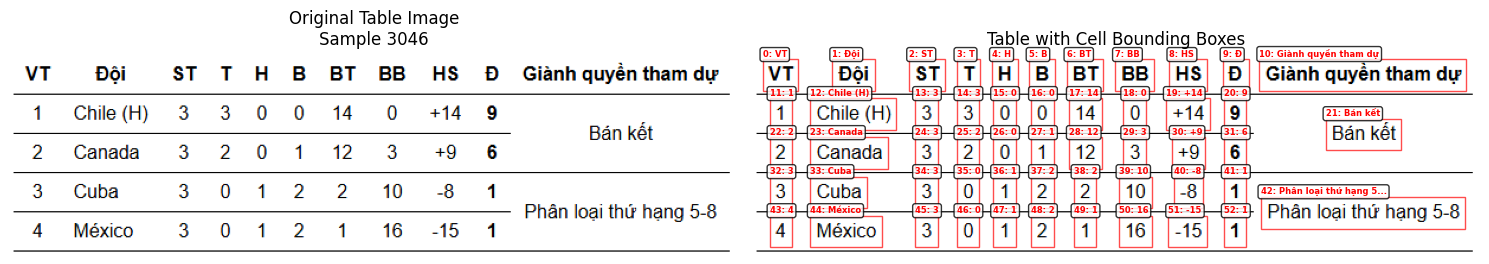


Sample 3046 Details:
Image path: F:/data\vitabset\test\8716.png
Image size: (615, 170)
Split: test
Structure instances: 1
Content instances: 53
Structure text: <thead><tr><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td...
First few cell texts:
  Cell 0: 'VT' at [8, 5, 38, 32]
  Cell 1: 'Đội' at [67, 5, 103, 32]
  Cell 2: 'ST' at [132, 5, 162, 32]
  Cell 3: 'T' at [172, 5, 192, 32]
  Cell 4: 'H' at [202, 5, 224, 32]


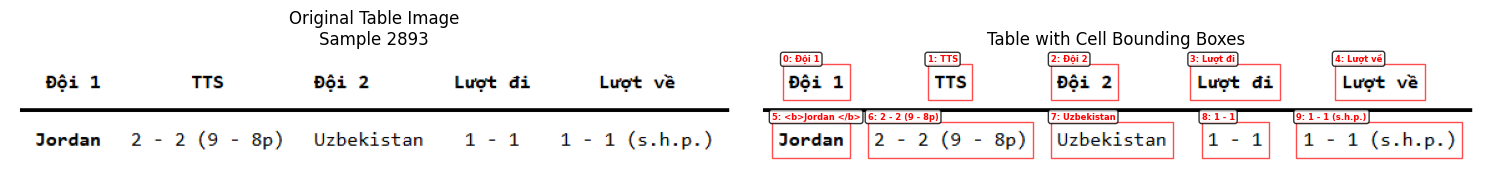


Sample 2893 Details:
Image path: F:/data\vitabset\test\84104.png
Image size: (584, 100)
Split: test
Structure instances: 1
Content instances: 10
Structure text: <thead><tr><td></td><td></td><td></td><td></td><td></td></tr></thead><tbody><tr><td></td><td></td><t...
First few cell texts:
  Cell 0: 'Đội 1' at [24, 9, 78, 38]
  Cell 1: 'TTS' at [140, 9, 176, 38]
  Cell 2: 'Đội 2' at [239, 9, 293, 38]
  Cell 3: 'Lượt đi' at [351, 9, 423, 38]
  Cell 4: 'Lượt về' at [467, 9, 539, 38]


In [76]:
def visualize_table_sample(dataset, idx, figsize=(15, 10)):
    """Visualize a table sample with structure and cell annotations."""
    data_info = dataset.get_data_info(idx)
    
    # Load image
    img_path = data_info['img_path']
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return
    
    image = Image.open(img_path)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot original image
    axes[0].imshow(image)
    axes[0].set_title(f'Original Table Image\nSample {idx}')
    axes[0].axis('off')
    
    # Plot image with cell bboxes
    axes[1].imshow(image)
    axes[1].set_title('Table with Cell Bounding Boxes')
    
    # Draw bounding boxes for cells
    cell_count = 0
    for instance in data_info['instances']:
        if 'bbox' in instance:
            bbox = instance['bbox']
            x0, y0, x1, y1 = bbox
            width = x1 - x0
            height = y1 - y0
            
            # Create rectangle patch
            rect = patches.Rectangle(
                (x0, y0), width, height,
                linewidth=1, edgecolor='red', facecolor='none', alpha=0.7
            )
            axes[1].add_patch(rect)
            
            # Add cell text if available
            cell_text = instance.get('text', '')
            if cell_text and len(cell_text) > 0:
                axes[1].text(
                    x0, y0-2, f'{cell_count}: {cell_text[:20]}' + ('...' if len(cell_text) > 20 else ''), 
                    fontsize=6, color='red', weight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
                )
            cell_count += 1
    
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print structure and content information
    print(f"\nSample {idx} Details:")
    print(f"Image path: {img_path}")
    print(f"Image size: {image.size}")
    print(f"Split: {data_info['img_info'].get('split', 'unknown')}")
    
    structure_instances = [inst for inst in data_info['instances'] if inst.get('task_type') == 'structure']
    content_instances = [inst for inst in data_info['instances'] if inst.get('task_type') == 'content']
    
    print(f"Structure instances: {len(structure_instances)}")
    print(f"Content instances: {len(content_instances)}")
    
    if structure_instances:
        print(f"Structure text: {structure_instances[0].get('text', '')[:100]}...")
    
    if content_instances:
        print(f"First few cell texts:")
        for i, inst in enumerate(content_instances[:5]):
            cell_text = inst.get('text', '<empty>')
            bbox = inst.get('bbox', [])
            print(f"  Cell {i}: '{cell_text}' at {bbox}")

# Display first few table samples
for i in [random.randint(0, len(table_dataset) - 1) for _ in range(3)]:
    visualize_table_sample(table_dataset, i)

## Display Cell Samples
Visualize individual cell samples from the cell dataset.

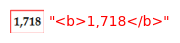

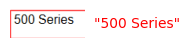

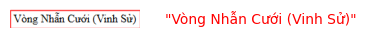

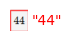

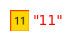

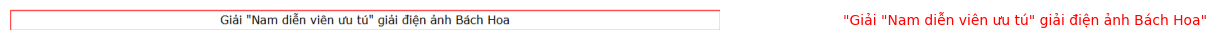

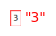

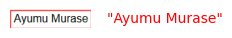

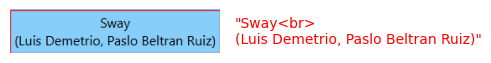

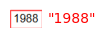

In [81]:
def visualize_cell_sample(dataset, idx):
    """Visualize a single cell sample."""
    data_info = dataset[idx]
    
    if 'img' not in data_info:
        print(f"No cropped image available for sample {idx}")
        return
    
    # Get cell image and info
    cell_image = data_info['img']
    cell_text = data_info['instances'][0].get('text', '<empty>').replace("<br>", "<br>\n")
    
    # Convert BGR to RGB for matplotlib
    if len(cell_image.shape) == 3:
        cell_image_rgb = cell_image[:, :, ::-1]
    else:
        cell_image_rgb = cell_image

    img_size = cell_image_rgb.shape[:2]
    scale = 100 # plt had dpi = 100 by default
    figsize = (img_size[1] / scale, img_size[0] / scale)  # Scale figsize based on image size
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)
    
    ax.imshow(cell_image_rgb)
    ax.add_patch(patches.Rectangle( (0, 0), img_size[1], img_size[0], linewidth=1, edgecolor='red', facecolor='none', alpha=0.7))
    # Hiển thị chữ bên phải, ngay sau ảnh
    ax.set_title("")  # Không dùng title phía trên

    # Tính vị trí để vẽ chữ bên phải ảnh
    fig_width, fig_height = fig.get_size_inches() * fig.dpi
    img_w, img_h = img_size[1], img_size[0]
    text_x = img_w + 10  # 10 pixel cách mép phải ảnh
    text_y = img_h // 2

    # Thêm chữ vào figure (không phải axes) để nó nằm ngoài ảnh
    fig.text(
        0.98, 0.5, f'"{cell_text}"',
        va='center', ha='left', fontsize=10, color='red',
        transform=fig.transFigure
    )
    ax.axis('off')
    plt.show()

for i in [random.randint(0, len(cell_dataset) - 1) for _ in range(10)]:
    visualize_cell_sample(cell_dataset, i)

## Dataset Statistics
Analyze the dataset statistics and distribution.

DATASET STATISTICS

Table Dataset:
  Total samples: 10209
  Structure instances (first 100 tables): 100
  Content instances (first 100 tables): 2955
  Non-empty cells: 2955
  Empty cells: 0

Cell Dataset:
  Total cell samples: 522260
  Average cell text length: 13.99
  Max cell text length: 237
  Min cell text length: 1


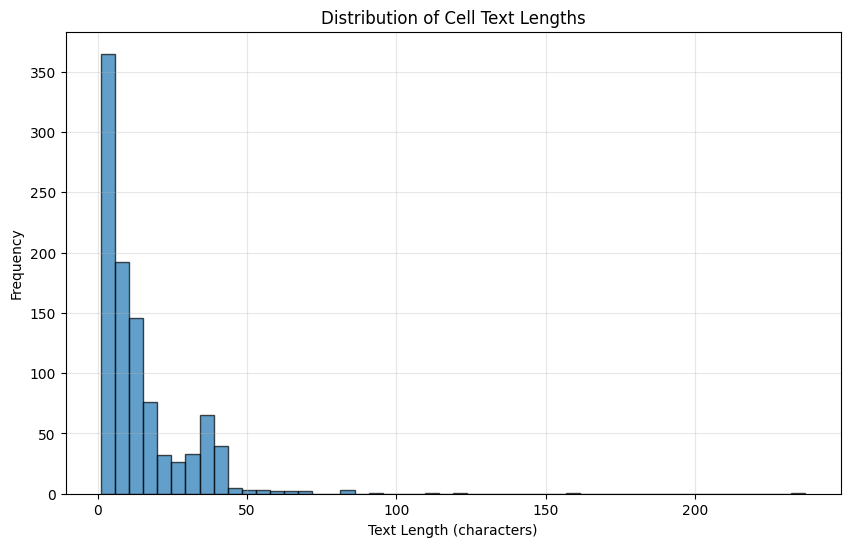

In [82]:
# Analyze dataset statistics
def analyze_dataset_statistics(table_dataset, cell_dataset):
    """Analyze and display dataset statistics."""
    
    print("DATASET STATISTICS")
    print("="*50)
    
    # Table dataset statistics
    print(f"\nTable Dataset:")
    print(f"  Total samples: {len(table_dataset)}")
    
    # Count instances by task type
    structure_count = 0
    content_count = 0
    empty_cells = 0
    non_empty_cells = 0
    
    for i in range(min(100, len(table_dataset))):  # Sample first 100 for analysis
        data_info = table_dataset.get_data_info(i)
        for instance in data_info['instances']:
            if instance.get('task_type') == 'structure':
                structure_count += 1
            elif instance.get('task_type') == 'content':
                content_count += 1
                if instance.get('text', '').strip():
                    non_empty_cells += 1
                else:
                    empty_cells += 1
    
    print(f"  Structure instances (first 100 tables): {structure_count}")
    print(f"  Content instances (first 100 tables): {content_count}")
    print(f"  Non-empty cells: {non_empty_cells}")
    print(f"  Empty cells: {empty_cells}")
    
    # Cell dataset statistics
    print(f"\nCell Dataset:")
    print(f"  Total cell samples: {len(cell_dataset)}")
    
    # Analyze cell text lengths
    text_lengths = []
    for i in range(min(1000, len(cell_dataset))):  # Sample first 1000 cells
        data_info = cell_dataset.get_data_info(i)
        cell_text = data_info['instances'][0].get('text', '')
        text_lengths.append(len(cell_text))
    
    if text_lengths:
        print(f"  Average cell text length: {np.mean(text_lengths):.2f}")
        print(f"  Max cell text length: {max(text_lengths)}")
        print(f"  Min cell text length: {min(text_lengths)}")
        
        # Plot text length distribution
        plt.figure(figsize=(10, 6))
        plt.hist(text_lengths, bins=50, alpha=0.7, edgecolor='black')
        plt.title('Distribution of Cell Text Lengths')
        plt.xlabel('Text Length (characters)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        plt.show()

# Run analysis
analyze_dataset_statistics(table_dataset, cell_dataset)